In [1]:
%matplotlib inline
from IPython.display import Image
import numpy as np
import matplotlib.pyplot as plt

import openmc

In [2]:
# Instantiate some Nuclides
h1 = openmc.Nuclide('H1')
b10 = openmc.Nuclide('B10')
o16 = openmc.Nuclide('O16')
u235 = openmc.Nuclide('U235')
u238 = openmc.Nuclide('U238')
zr90 = openmc.Nuclide('Zr90')

In [3]:
# 1.6 enriched fuel
fuel = openmc.Material(name='1.6% Fuel')
fuel.set_density('g/cm3', 10.31341)
fuel.add_nuclide(u235, 3.7503e-4)
fuel.add_nuclide(u238, 2.2625e-2)
fuel.add_nuclide(o16, 4.6007e-2)

# borated water
water = openmc.Material(name='Borated Water')
water.set_density('g/cm3', 0.740582)
water.add_nuclide(h1, 4.9457e-2)
water.add_nuclide(o16, 2.4732e-2)
water.add_nuclide(b10, 8.0042e-6)

# zircaloy
zircaloy = openmc.Material(name='Zircaloy')
zircaloy.set_density('g/cm3', 6.55)
zircaloy.add_nuclide(zr90, 7.2758e-3)

In [4]:
# Instantiate a Materials collection
materials_file = openmc.Materials((fuel, water, zircaloy))
materials_file.default_xs = '71c'

# Export to "materials.xml"
materials_file.export_to_xml()

In [5]:
# Create cylinders for the fuel and clad
fuel_outer_radius = openmc.ZCylinder(x0=0.0, y0=0.0, R=0.39218)
clad_outer_radius = openmc.ZCylinder(x0=0.0, y0=0.0, R=0.45720)

# Create boundary planes to surround the geometry
# Use both reflective and vacuum boundaries to make life interesting
min_x = openmc.XPlane(x0=-0.63, boundary_type='reflective')
max_x = openmc.XPlane(x0=+0.63, boundary_type='reflective')
min_y = openmc.YPlane(y0=-0.63, boundary_type='reflective')
max_y = openmc.YPlane(y0=+0.63, boundary_type='reflective')
min_z = openmc.ZPlane(z0=-0.63, boundary_type='reflective')
max_z = openmc.ZPlane(z0=+0.63, boundary_type='reflective')

In [6]:
# Create a Universe to encapsulate a fuel pin
pin_cell_universe = openmc.Universe(name='1.6% Fuel Pin')

# Create fuel Cell
fuel_cell = openmc.Cell(name='1.6% Fuel')
fuel_cell.fill = fuel
fuel_cell.region = -fuel_outer_radius
pin_cell_universe.add_cell(fuel_cell)

# Create a clad Cell
clad_cell = openmc.Cell(name='1.6% Clad')
clad_cell.fill = zircaloy
clad_cell.region = +fuel_outer_radius & -clad_outer_radius
pin_cell_universe.add_cell(clad_cell)

# Create a moderator Cell
moderator_cell = openmc.Cell(name='1.6% Moderator')
moderator_cell.fill = water
moderator_cell.region = +clad_outer_radius
pin_cell_universe.add_cell(moderator_cell)

In [7]:
# Create root Cell
root_cell = openmc.Cell(name='root cell')
root_cell.fill = pin_cell_universe

# Add boundary planes
root_cell.region = +min_x & -max_x & +min_y & -max_y & +min_z & -max_z

# Create root Universe
root_universe = openmc.Universe(universe_id=0, name='root universe')
root_universe.add_cell(root_cell)

In [8]:
# Create Geometry and set root Universe
geometry = openmc.Geometry()
geometry.root_universe = root_universe

In [9]:
# Export to "geometry.xml"
geometry.export_to_xml()

In [10]:
# OpenMC simulation parameters
batches = 100
inactive = 10
particles = 5000

# Instantiate a Settings object
settings_file = openmc.Settings()
settings_file.batches = batches
settings_file.inactive = inactive
settings_file.particles = particles

# Create an initial uniform spatial source distribution over fissionable zones
bounds = [-0.63, -0.63, -0.63, 0.63, 0.63, 0.63]
uniform_dist = openmc.stats.Box(bounds[:3], bounds[3:], only_fissionable=True)
settings_file.source = openmc.source.Source(space=uniform_dist)

# Export to "settings.xml"
settings_file.export_to_xml()

In [11]:
# Instantiate a Plot
plot = openmc.Plot(plot_id=1)
plot.filename = 'materials-xy'
plot.origin = [0, 0, 0]
plot.width = [1.26, 1.26]
plot.pixels = [250, 250]
plot.color = 'mat'

# Instantiate a Plots collection and export to "plots.xml"
plot_file = openmc.Plots([plot])
plot_file.export_to_xml()

In [12]:
# Run openmc in plotting mode
openmc.plot_geometry(output=False)

0

In [13]:
# Instantiate an empty Tallies object
tallies_file = openmc.Tallies()

In [14]:
# Create mesh which will be used for tally
mesh = openmc.Mesh()
mesh.dimension = [100, 100]
mesh.lower_left = [-0.63, -0.63]
mesh.upper_right = [0.63, 0.63]

# Create mesh filter for tally
mesh_filter = openmc.MeshFilter(mesh)
mesh_filter.mesh = mesh

# Create mesh tally to score flux and fission rate
tally = openmc.Tally(name='flux')
tally.filters = [mesh_filter]
tally.scores = ['flux', 'fission']
tallies_file.append(tally)

In [15]:
# Export to "tallies.xml"
tallies_file.export_to_xml()

In [16]:
# Run OpenMC!
openmc.run()


                               %%%%%%%%%%%%%%%
                          %%%%%%%%%%%%%%%%%%%%%%%%
                       %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                     %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                   %%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                ###############      %%%%%%%%%%%%%%%%%%%%%%%%
               ##################     %%%%%%%%%%%%%%%%%%%%%%%
               ###################     %%%%%%%%%%%%%%%%%%%%%%%
               ####################     %%%%%%%%%%%%%%%%%%%%%%
               #####################     %%%%%%%%%%%%%%%%%%%%%
               ######################     %%%%%%%%%%%%%%%%%%%%
               #######################     %%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%

0

In [17]:
# Load the statepoint file
sp = openmc.StatePoint('statepoint.100.h5')

In [18]:
tally = sp.get_tally(scores=['flux'])
print(tally)

Tally
	ID             =	10000
	Name           =	flux
	Filters        =	MeshFilter
	Nuclides       =	total 
	Scores         =	[u'flux', u'fission']
	Estimator      =	tracklength



In [19]:
tally.sum

array([[[ 0.40981574,  0.        ]],

       [[ 0.40963388,  0.        ]],

       [[ 0.41117481,  0.        ]],

       ..., 
       [[ 0.41179009,  0.        ]],

       [[ 0.41329412,  0.        ]],

       [[ 0.41494587,  0.        ]]])

In [20]:
print(tally.mean.shape)
(tally.mean, tally.std_dev)

(10000, 1, 2)


(array([[[ 0.00455351,  0.        ]],
 
        [[ 0.00455149,  0.        ]],
 
        [[ 0.00456861,  0.        ]],
 
        ..., 
        [[ 0.00457545,  0.        ]],
 
        [[ 0.00459216,  0.        ]],
 
        [[ 0.00461051,  0.        ]]]),
 array([[[  2.00748004e-05,   0.00000000e+00]],
 
        [[  1.75039529e-05,   0.00000000e+00]],
 
        [[  1.96093103e-05,   0.00000000e+00]],
 
        ..., 
        [[  1.69721143e-05,   0.00000000e+00]],
 
        [[  1.58964240e-05,   0.00000000e+00]],
 
        [[  1.81009205e-05,   0.00000000e+00]]]))

In [21]:
flux = tally.get_slice(scores=['flux'])
fission = tally.get_slice(scores=['fission'])
print(flux)

Tally
	ID             =	10001
	Name           =	flux
	Filters        =	MeshFilter
	Nuclides       =	total 
	Scores         =	[u'flux']
	Estimator      =	tracklength



In [22]:
flux.std_dev.shape = (100, 100)
flux.mean.shape = (100, 100)
fission.std_dev.shape = (100, 100)
fission.mean.shape = (100, 100)

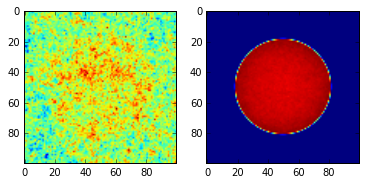

In [23]:
fig = plt.subplot(121)
fig.imshow(flux.mean)
fig2 = plt.subplot(122)
fig2.imshow(fission.mean)

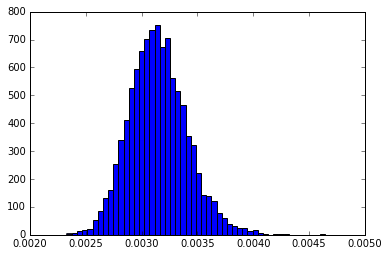

In [24]:
# Determine relative error
relative_error = np.zeros_like(flux.std_dev)
nonzero = flux.mean > 0
relative_error[nonzero] = flux.std_dev[nonzero] / flux.mean[nonzero]

# distribution of relative errors
ret = plt.hist(relative_error[nonzero], bins=50)

In [25]:
sp.source

array([ (1.0, [0.08865821621194064, 0.3784631548839458, 0.3904972254761878], [-0.1326194120629367, 0.6232164386612264, 0.7707226233389667], 1192346.6320091304, 0),
       (1.0, [0.08865821621194064, 0.3784631548839458, 0.3904972254761878], [-0.6644604177986176, -0.6182443857504494, 0.41984072297352965], 356616.8122252148, 0),
       (1.0, [-0.0524358478826145, -0.2989344511695743, -0.17188682459930016], [0.26140031911472983, 0.8973965547376798, 0.35545646246996265], 836460.5302888667, 0),
       ...,
       (1.0, [-0.1061743912824093, 0.2687838889464804, 0.3209783107825243], [0.04074864852534854, 0.6722488179526406, -0.7392029994559244], 4419569.703536596, 0),
       (1.0, [-0.1061743912824093, 0.2687838889464804, 0.3209783107825243], [0.2921501228867853, 0.9089796683155593, 0.2973285527596903], 2716068.3317314633, 0),
       (1.0, [0.24742871049665383, 0.2887788071034633, 0.12388141872813332], [0.9088435703078486, -0.040848021273558396, -0.4151322727373983], 1005076.8690394862, 0)], 


In [26]:
sp.source['uvw']

array([[-0.13261941,  0.62321644,  0.77072262],
       [-0.66446042, -0.61824439,  0.41984072],
       [ 0.26140032,  0.89739655,  0.35545646],
       ..., 
       [ 0.04074865,  0.67224882, -0.739203  ],
       [ 0.29215012,  0.90897967,  0.29732855],
       [ 0.90884357, -0.04084802, -0.41513227]])

1.0


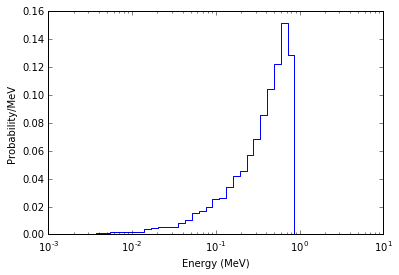

In [27]:
# Create log-spaced energy bins from 1 keV to 100 MeV
energy_bins = np.logspace(-3,1)

# Calculate pdf for source energies
probability, bin_edges = np.histogram(sp.source['uvw'], energy_bins, density=True)
# Make sure integrating the PDF gives us unity
print(sum(probability*np.diff(energy_bins)))

# Plot source energy PDF
plt.semilogx(energy_bins[:-1], probability*np.diff(energy_bins), linestyle='steps')
plt.xlabel('Energy (MeV)')
plt.ylabel('Probability/MeV')

(-0.5, 0.5)

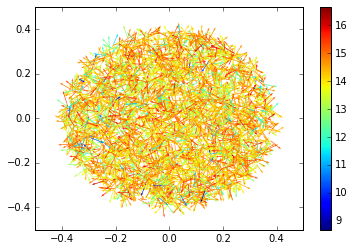

In [28]:
plt.quiver(sp.source['xyz'][:,0], sp.source['xyz'][:,1],
           sp.source['uvw'][:,0], sp.source['uvw'][:,1],
           np.log(sp.source['E']), cmap='jet', scale=20.0)
plt.colorbar()
plt.xlim((-0.5,0.5))
plt.ylim((-0.5,0.5))